Company XYZ is an online video streaming company, just like YouTube or Dailymotion.
The Head of Product has identified as a major problem for the site a very high home page dropoff rate. That is, users come to the home-page and then leave the site without taking any action
or watching any video. Since customer acquisition costs are very high, this is a huge problem:
the company is spending a lot of money to acquire users who don't generate any revenue.
Currently, the videos shown on the home page to new users are manually chosen. The Head of
Product had this idea of creating a new recommended video section on the home page.

In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier,export_graphviz

import warnings
warnings.simplefilter('ignore')

In [2]:
df_count = pd.read_csv('video_count.csv')
df_feature = pd.read_csv('video_features.csv')

In [3]:
df = pd.merge(left=df_count, right=df_feature, on='video_id', how='left')

In [4]:
df

,video_id,count,date,video_length,video_language,video_upload_date,video_quality
0,2303,22,2015-01-07,1071,Cn,2014-12-10,1080p
1,1193,54854,2015-01-12,770,Other,2014-12-07,720p
2,1219,1788779,2015-01-03,904,Cn,2014-12-12,240p
3,1472,234,2015-01-04,157,Other,2014-12-10,240p
4,2947,14407,2015-01-08,446,Cn,2014-12-19,480p
...,...,...,...,...,...,...,...
41770,2168,72747,2015-01-02,335,En,2014-12-07,480p
41771,2710,2986363,2015-01-08,418,En,2014-12-17,720p
41772,893,733,2015-01-08,561,Other,2014-12-24,1080p
41773,435,178472,2015-01-07,1239,Es,2014-12-04,360p


In [5]:
# define a function to find each video's count and trend statistics data
def video_stat(df):
    count = df.sort_values(by='date')['count'].values
    trend = (count[1:] - count[:-1]) / count[:-1]
    
    count_descr = pd.Series(count).describe()
    trend_descr = pd.Series(trend).describe()
    
    # find mean, 25%, 50%, 75% of video count and trend
    indexs = ['count_mean', 'count_25%', 'count_50%', 'count_75%', 'trend_mean', 'trend_25%', 'trend_50%', 'trend_75%']
    count_stat = [count_descr['mean'],count_descr['25%'],count_descr['50%'],count_descr['75%']]
    trend_stat = [trend_descr['mean'],trend_descr['25%'],trend_descr['50%'],trend_descr['75%']]
    
    return pd.Series(count_stat+trend_stat, index=indexs)

In [6]:
# apply our function
df_stat_info = df.groupby('video_id').apply(video_stat)
df_stat_info

,count_mean,count_25%,count_50%,count_75%,trend_mean,trend_25%,trend_50%,trend_75%
video_id,,,,,,,,
1,7.063560e+04,41099.0,65907.0,96335.0,-0.127437,-0.186381,-0.151384,-0.067977
2,1.737141e+06,1673415.5,1718352.0,1782226.5,-0.014184,-0.061459,-0.043876,0.030687
3,2.292781e+06,2132336.5,2247587.0,2436222.5,0.008923,-0.028293,-0.001068,0.056393
4,2.740392e+06,2611162.0,2719547.0,2880268.5,0.011310,-0.027125,0.001606,0.050860
5,4.479973e+05,255574.5,388594.0,609508.0,-0.111811,-0.177432,-0.133447,-0.012729
...,...,...,...,...,...,...,...,...
2996,1.273819e+05,72539.0,94563.0,175480.5,-0.118632,-0.175297,-0.117628,-0.066264
2997,1.652645e+06,1554165.5,1587549.0,1733534.0,0.025721,-0.018800,0.052025,0.067090
2998,2.966667e+01,26.5,32.0,33.5,-0.033837,-0.075152,-0.041051,0.000000


In [23]:
# check missing values
print('Missing value in df_count: ')
print(df_count.isna().sum())
print(" ")
print('Missing value in df_feature: ')
print(df_feature.isna().sum())

Missing value in df_count: 
video_id    0
count       0
date        0
dtype: int64
 
Missing value in df_feature: 
video_id             0
video_length         0
video_language       0
video_upload_date    0
video_quality        0
dtype: int64


# Question01:
Classify each video into one the 3 categories below and explain the approach
1. "Hot" - means trending up. These videos are candidate to be shown.
2. "Stable and Popular" - video view counts are flat, but very high. These videos are candidates to be shown too.
3. "Everything else" - these videos won't be shown.

### (1) Popular video

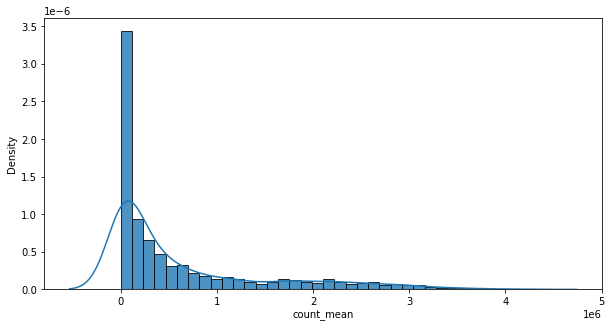

In [27]:
# check the distribution of video count
fig, ax = plt.subplots(figsize=(10,5))

hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.8}

sns.distplot(df_stat_info['count_mean'],hist_kws=hist_kws)

plt.show()

* we can set a threshold, if a video's count mean is higher than the threshold, we will say it is popular video
* Set the threshould as 1,500,000

In [10]:
# set threshold and get the popular videos
threshold = 1500000
pop_vid = df_stat_info.loc[df_stat_info['count_mean']>threshold,:]
pop_vid

,count_mean,count_25%,count_50%,count_75%,trend_mean,trend_25%,trend_50%,trend_75%
video_id,,,,,,,,
2,1.737141e+06,1673415.5,1718352.0,1782226.5,-0.014184,-0.061459,-0.043876,0.030687
3,2.292781e+06,2132336.5,2247587.0,2436222.5,0.008923,-0.028293,-0.001068,0.056393
4,2.740392e+06,2611162.0,2719547.0,2880268.5,0.011310,-0.027125,0.001606,0.050860
8,2.049360e+06,1950028.5,2042499.0,2154066.5,0.004013,-0.034195,0.009304,0.046501
14,1.593414e+06,1380598.0,1502636.0,1793568.0,-0.011086,-0.074206,-0.005127,0.049045
...,...,...,...,...,...,...,...,...
2975,1.944652e+06,1899143.5,1919602.0,2027885.0,0.003070,-0.056649,0.006025,0.052164
2982,1.752863e+06,1684260.5,1703703.0,1830293.0,-0.003853,-0.055605,-0.035350,0.077788
2986,2.202956e+06,2021778.0,2263828.0,2461996.5,-0.016777,-0.059337,-0.024820,0.026561


### (2) Hot video

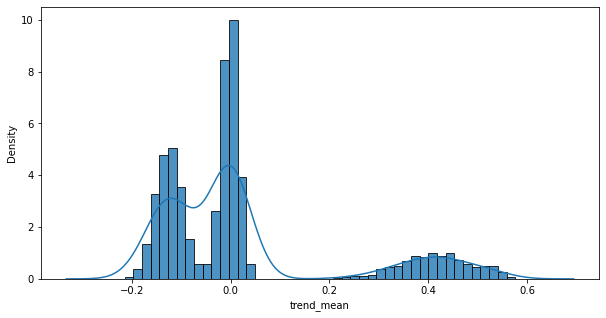

In [11]:
# check the distribution of video trend
fig, ax = plt.subplots(figsize=(10,5))
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.8}

sns.distplot(df_stat_info['trend_mean'],hist_kws=hist_kws)

plt.show()

* We can set a threshold, if a video's trend mean is higher than the threshold, we will say it is hot video
* Set the threshould as 0.2

In [12]:
# set threshold and get the hot videos
threshold = 0.2
hot_vid = df_stat_info.loc[df_stat_info['trend_mean']>threshold,:]
hot_vid

,count_mean,count_25%,count_50%,count_75%,trend_mean,trend_25%,trend_50%,trend_75%
video_id,,,,,,,,
10,8903.133333,1882.5,5483.0,11318.5,0.353819,0.238332,0.324975,0.416434
13,91228.200000,16688.0,45930.0,153985.5,0.350798,0.171082,0.373361,0.514471
15,6184.400000,1190.0,1705.0,6231.5,0.381382,0.026856,0.471749,0.656678
28,105011.600000,14399.0,30084.0,152599.5,0.367767,0.206640,0.300966,0.502638
29,78372.866667,16789.5,45226.0,131717.0,0.271285,0.046231,0.293353,0.455947
...,...,...,...,...,...,...,...,...
2979,86818.133333,16033.0,36143.0,106230.0,0.387470,0.100697,0.360976,0.630981
2981,126270.333333,37534.0,86060.0,122605.0,0.350858,0.065007,0.342286,0.590940
2984,1933.933333,292.0,785.0,2195.5,0.359965,0.130986,0.336027,0.593407


* The rest videos are "everything else".

# Question02:
What are the main characteristics of the "hot videos"?

In [14]:
# create a column to show the video is hot video or not, 1 is hot 0 is not
df['hot'] = 0
df.loc[df['video_id'].isin(hot_vid.index),'hot'] = 1

# create day of week column for further analysis
df['video_upload_date'] = pd.to_datetime(df['video_upload_date'])
df['upload_dayofweek'] = df['video_upload_date'].dt.dayofweek
# becuase dt.dayofweek set Monday as 0, Tuesday as 1 so on.. , so I change it to Week Abbreviations, it will be more intuitive
df['dayofweek_name'] = df['upload_dayofweek'].map({0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'})
df

,video_id,count,date,video_length,video_language,video_upload_date,video_quality,hot,upload_dayofweek,dayofweek_name
0,2303,22,2015-01-07,1071,Cn,2014-12-10,1080p,0,2,Wed
1,1193,54854,2015-01-12,770,Other,2014-12-07,720p,0,6,Sun
2,1219,1788779,2015-01-03,904,Cn,2014-12-12,240p,0,4,Fri
3,1472,234,2015-01-04,157,Other,2014-12-10,240p,0,2,Wed
4,2947,14407,2015-01-08,446,Cn,2014-12-19,480p,1,4,Fri
...,...,...,...,...,...,...,...,...,...,...
41770,2168,72747,2015-01-02,335,En,2014-12-07,480p,0,6,Sun
41771,2710,2986363,2015-01-08,418,En,2014-12-17,720p,0,2,Wed
41772,893,733,2015-01-08,561,Other,2014-12-24,1080p,1,2,Wed
41773,435,178472,2015-01-07,1239,Es,2014-12-04,360p,0,3,Thu


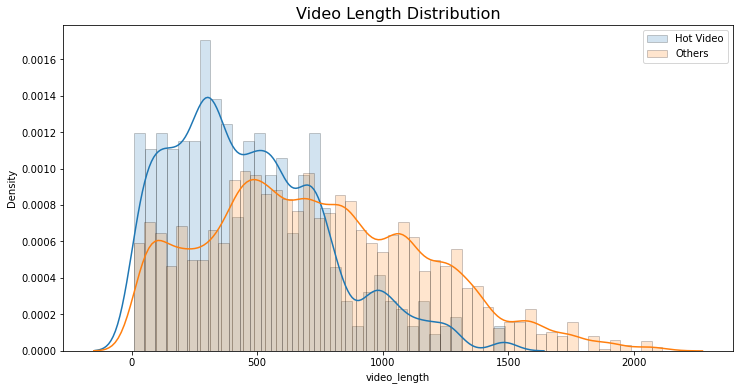

In [29]:
# video length
fig, ax = plt.subplots(figsize=(12,6))
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

sns.distplot(df.loc[df['hot']==1,'video_length'],hist_kws=hist_kws, label='Hot Video')
sns.distplot(df.loc[df['hot']==0,'video_length'],hist_kws=hist_kws, label='Others')
ax.set_title('Video Length Distribution', fontsize=16)


plt.legend(loc='best')
plt.show()

* The video length of **hot videos** are **shorter** than others

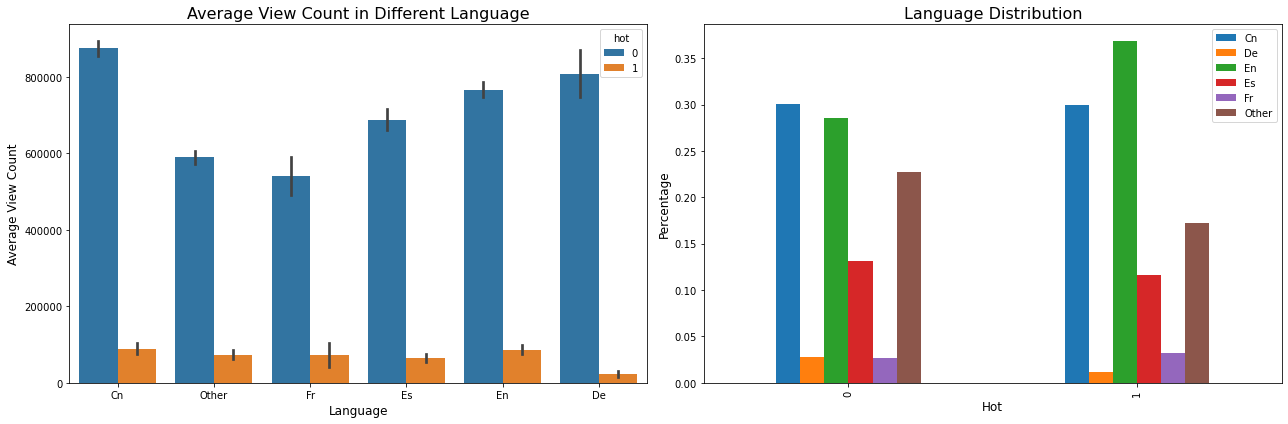

In [16]:
# video language
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

sns.barplot(x='video_language', y='count', data=df, hue='hot',ax=ax[0])
ax[0].set_xlabel('Language', fontsize=12)
ax[0].set_ylabel('Average View Count', fontsize=12)
ax[0].set_title('Average View Count in Different Language', fontsize=16)

lang = df.groupby('hot')['video_language'].apply(lambda x: x.value_counts(normalize=True)).unstack()
lang.plot(kind='bar', ax=ax[1])
ax[1].set_xlabel('Hot', fontsize=12)
ax[1].set_ylabel('Percentage', fontsize=12)
ax[1].set_title('Language Distribution', fontsize=16)

plt.tight_layout()
plt.show()

* Lots of hot videos are **english** videos

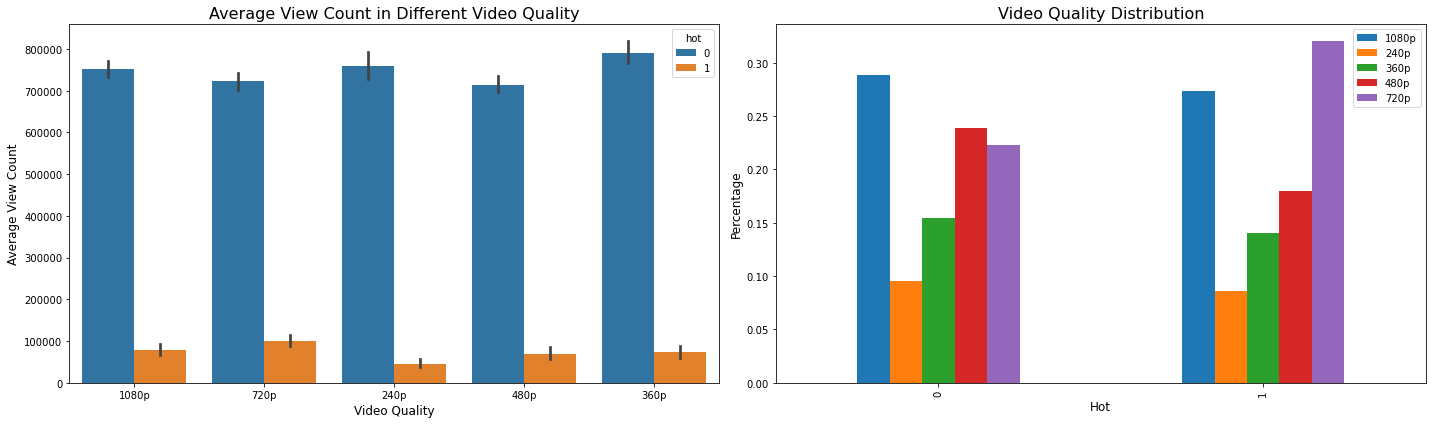

In [17]:
# video quality

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

sns.barplot(x='video_quality', y='count', data=df, hue='hot',ax=ax[0])
ax[0].set_xlabel('Video Quality', fontsize=12)
ax[0].set_ylabel('Average View Count', fontsize=12)
ax[0].set_title('Average View Count in Different Video Quality', fontsize=16)

qual = df.groupby('hot')['video_quality'].apply(lambda x: x.value_counts(normalize=True)).unstack()
qual.plot(kind='bar', ax=ax[1])
ax[1].set_xlabel('Hot', fontsize=12)
ax[1].set_ylabel('Percentage', fontsize=12)
ax[1].set_title('Video Quality Distribution', fontsize=16)

plt.tight_layout()
plt.show()

* Lots of hot videos are **720p** video quality

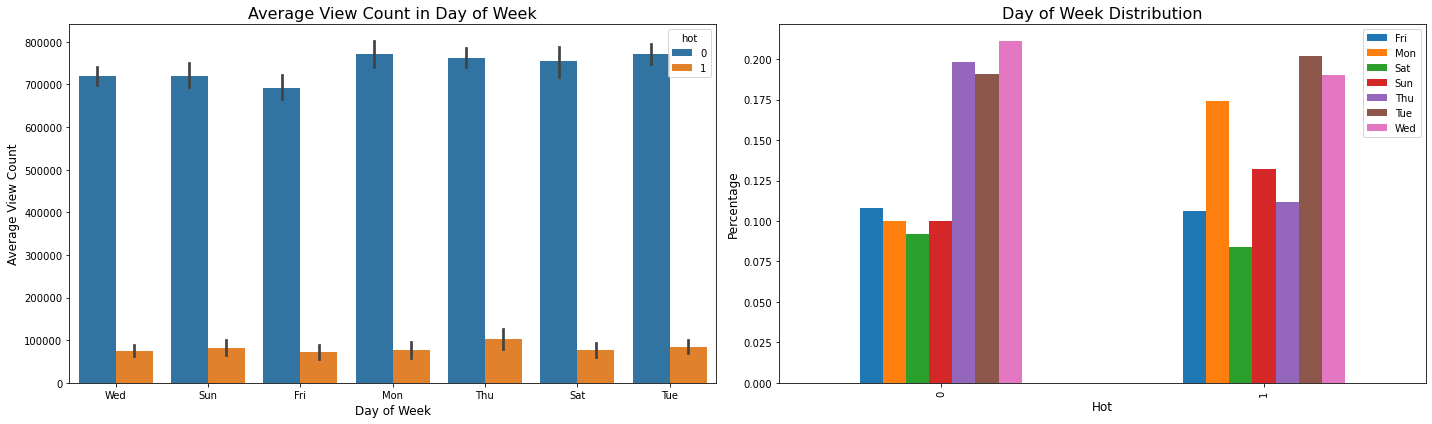

In [18]:
# Day of Week upload

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

sns.barplot(x='dayofweek_name', y='count', data=df, hue='hot',ax=ax[0])
ax[0].set_xlabel('Day of Week', fontsize=12)
ax[0].set_ylabel('Average View Count', fontsize=12)
ax[0].set_title('Average View Count in Day of Week', fontsize=16)

tem = df.groupby('hot')['dayofweek_name'].apply(lambda x: x.value_counts(normalize=True)).unstack()
tem.plot(kind='bar', ax=ax[1])
ax[1].set_xlabel('Hot', fontsize=12)
ax[1].set_ylabel('Percentage', fontsize=12)
ax[1].set_title('Day of Week Distribution', fontsize=16)

plt.tight_layout()
plt.show()

* The videos are uploaded on Sunday, Monday, and Tuesday are more likely to be Hot video

### Decision Tree Model
* Use Decision Tree Model to get feature importance and look at how Decision Tree Model choose the features.

In [31]:
df_model = df[['video_length', 'video_language', 'video_quality', 'hot', 'upload_dayofweek']]
df_model

,video_length,video_language,video_quality,hot,upload_dayofweek
0,1071,Cn,1080p,0,2
1,770,Other,720p,0,6
2,904,Cn,240p,0,4
3,157,Other,240p,0,2
4,446,Cn,480p,1,4
...,...,...,...,...,...
41770,335,En,480p,0,6
41771,418,En,720p,0,2
41772,561,Other,1080p,1,2
41773,1239,Es,360p,0,3


In [53]:
X = df_model.drop(labels='hot', axis=1)
y = df_model['hot']

# get dummy 
X = pd.get_dummies(X, columns=['video_language', 'video_quality','upload_dayofweek'],prefix='',prefix_sep='')
# "Other" is meaningless in this case
X.drop(labels='Other', axis=1)

X = X.rename(columns={'0': 'Mon', '1': 'Tue', '2': 'Wed', '3': 'Thu', '4': 'Fri', '5': 'Sat', '6': 'Sun'})
X

,video_length,Cn,De,En,Es,Fr,Other,1080p,240p,360p,480p,720p,Mon,Tue,Wed,Thu,Fri,Sat,Sun
0,1071,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,770,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
2,904,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,157,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
4,446,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41770,335,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
41771,418,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
41772,561,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0
41773,1239,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0


In [54]:
# build up Decision Tree
model = DecisionTreeClassifier(max_depth=4,min_samples_leaf=20,min_samples_split=20)
model.fit(X,y)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, min_samples_split=20)

<AxesSubplot:xlabel='Importance', ylabel='index'>

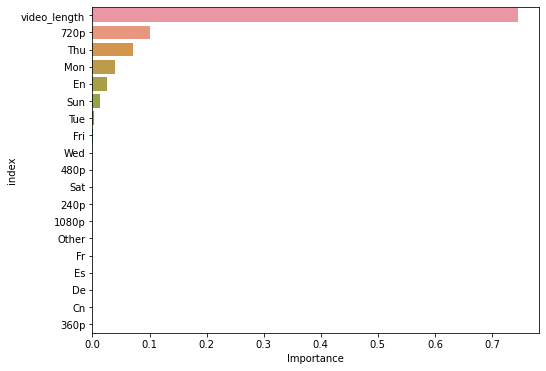

In [55]:
# get feature importances
feat_import = pd.Series(model.feature_importances_, index=X.columns)
feat_import = feat_import.sort_values(ascending=False).reset_index()
feat_import = feat_import.rename(columns={0: 'Importance'})

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(x='Importance', y='index', data=feat_import)

* As we can see above, the **video length is the critical feature for hot videos**

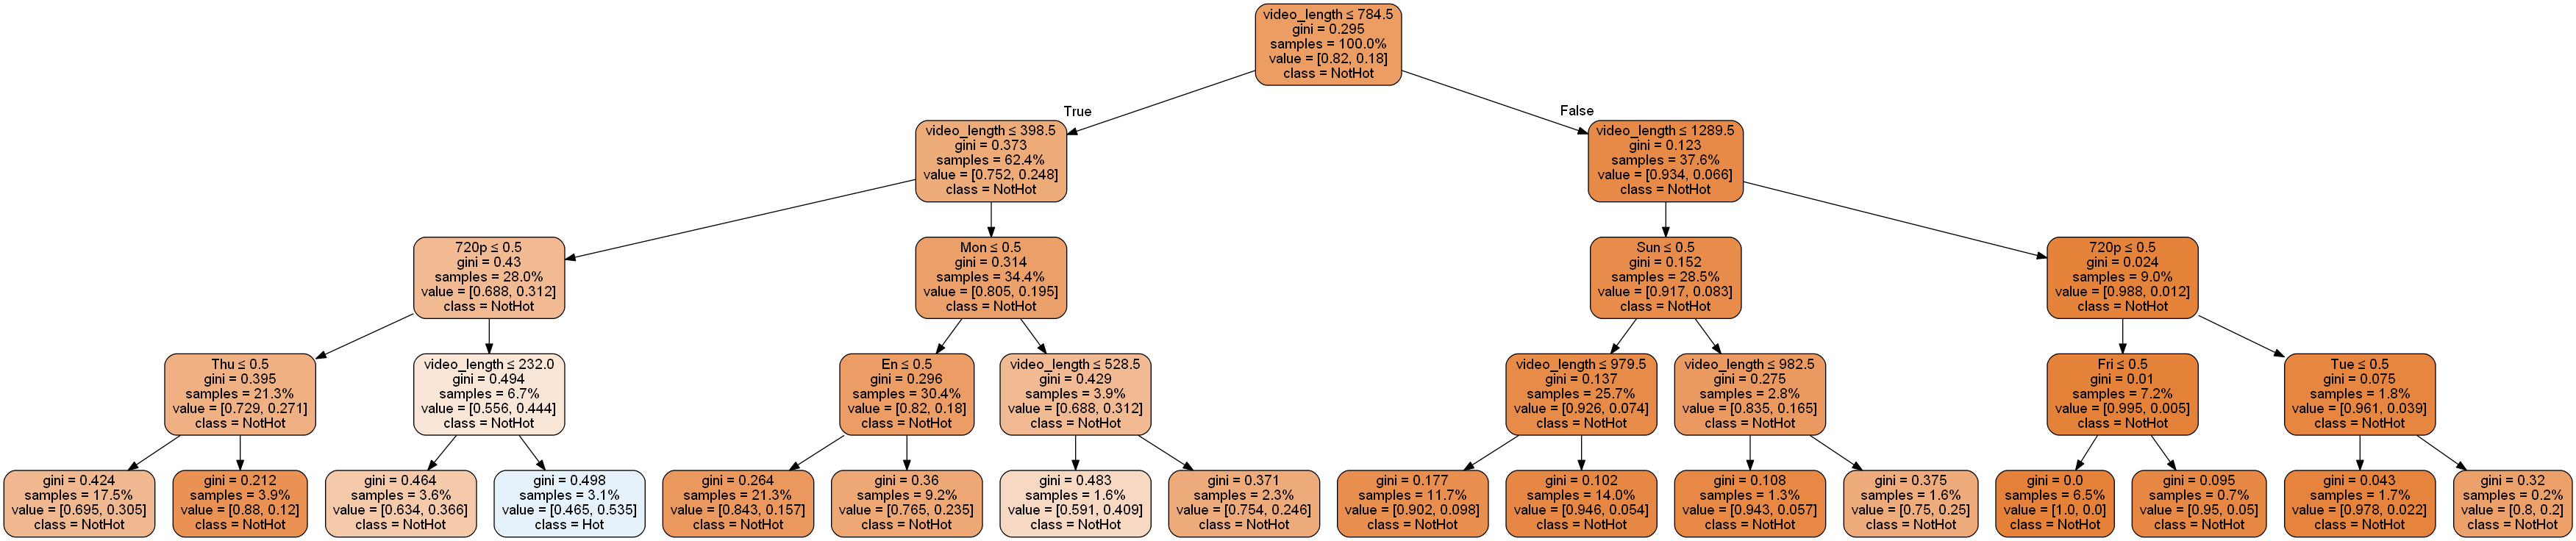

In [56]:
# tree plot

from io import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(model, out_file=dot_data, filled=True, rounded=True, special_characters=True,
                feature_names = X.columns, class_names=['NotHot','Hot'], proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('tree_plot.png')
Image(graph.create_png())

Based on tree plot:
1. The highest ratio to be a Hot video (the bule one, ratio=0.535), the videos contain the factors:
    * 232 < length < 398.5
    * Video quality is 720p
2. The second highest ratio to be a Hot video (7th leave from left, ratio=0.409), the videos contain the factors:
    * 398.5 < length < 528.5
    * Uploaded video on Monday
3. The third highest ratio to be a Hot video (3rd leave from left, ratio=0.366), the videos contain the factors:
    * length < 232
    * Video quality is 720p
4. The fourth highest ratio to be a Hot video (1st leave from left, ratio=0.333), the videos contain the factors:
    * length < 398.5
    * The videos uploaded are not on Thursday

#### Main characteristics of the "hot videos"
* Short videos are more likely to be Hot videos
* English videos are more likely to be Hot videos
* The videos are uploaded on Sunday, Monday, and Tuesday are more likely to be Hot videos

# Question03:
* After having identified the characteristics of the hot videos, how would you use this information from a product standpoint?

#### Ans:
1. We can build a model to predict whether the video will be Hot or not. The hot videos will be prioritized on the home page to attract poeple to watch
2. It is a clear tendency that short videos are hotter than others, so, we can push some hot short video to new users, so they can get a quick taste of the videos and want to continue exploring our website.
3. Because short videos are hot, we can create a new section only containing hot short videos, extend the time users spend on our site
4. For the creaters, when they upload their new videos, we can send them a notification that hot videos include what kind of features, so creaters can follow the same route to create some hot videos
5. English videos are more likely to be hot videos:
    * Maybe there are some translation problems in other languages
    * Maybe the other language UI of our site is not as friendly as the English UI (Some descriptions make user confused?)
    * Or maybe our site doesn't include other language countrys' local social network in our share button, so it is hard for them to share with their firends
6. The videos are uploaded on Sunday, Monday, and Tuesday are more likely to be Hot videos:
    * Maybe creaters have more free time to think and prepare a new idea on their next videos on Friday and Saturday, so that the videos uploaded on Sunday, Monday, and Tuesday will be more appealing
    * Maybe viewers have more free time to watch videos on Sunday, Monday, and Tuesday